# Dimensionality Reduction - Text Data

In [20]:
import numpy as np
import pandas as pd
from sklearn import datasets, decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap, TSNE, MDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
import re
from tqdm import tqdm
from numba import jit
import gc
import psutil
import os
import json

import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Dense, Dropout, Reshape, UpSampling2D, Conv2DTranspose, Conv2D, MaxPool2D, Flatten, \
                                    Embedding, LSTM, Dense, Dropout, Input, RepeatVector, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session

import faiss
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.csgraph import shortest_path

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch

from datasets import load_dataset
from transformers import BertTokenizer, TFBertModel
from sentence_transformers import SentenceTransformer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Function to get current memory usage
def memory_usage_psutil():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB
    return mem

# Check for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  0


## Standford IMDB

In [2]:
# Define stop words set
stop_words = ENGLISH_STOP_WORDS

# Define the lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove HTML tags using regular expressions
    text = re.sub(r'<.*?>', ' ', text.lower())
    # lowercase and remove apostrophe-s at end of words
    text = re.sub("'s\\b", " ", text.lower())
    # replace single letters followed by a period with a space
    text = re.sub(r"\b[a-zA-Z]\.", " ", text)
    # remove punctuation (any character that is not a word character)
    text = re.sub(r"[^\w\s]"," ", text)
    # # split text into words
    # tokens = word_tokenize(text)
    # # perform lemmatization on words with only alphabets and remove stop words
    # tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() 
    #           and lemmatizer.lemmatize(token) not in stop_words]
    # return ' '.join(tokens)
    return text

# Load the IMDB dataset
ds = load_dataset("scikit-learn/imdb")

# Preprocess the text data for all splits
def preprocess_function(data):
    data['review'] = [preprocess_text(text) for text in data['review']]
    return data

ds = ds['train'].map(preprocess_function, batched=True)

In [3]:
# Convert text data into TF-IDF vectors and split data into train and test sets
X = ds['review']
y = np.array(list(map(lambda x: 1 if x == 'positive' else 0, ds['sentiment'])))

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [4]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(acc)

0.9009


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Initialize the Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2', device=device)

# Convert text data to sentence embeddings
X_train_embeddings = model.encode(X_train, convert_to_tensor=True, device=device)
X_test_embeddings = model.encode(X_test, convert_to_tensor=True, device=device)

# Convert embeddings to numpy arrays
X_train_vec = X_train_embeddings.cpu().numpy()
X_test_vec = X_test_embeddings.cpu().numpy()

Using device: cuda


In [15]:
np.savez_compressed('data.npz', X_train_vec=X_train_vec, X_test_vec=X_test_vec, y_train=y_train, y_test=y_test)

In [5]:
# Load data
data = np.load('data.npz', allow_pickle=True)
X_train_vec = data['X_train_vec']
X_test_vec = data['X_test_vec']
y_train = data['y_train']
y_test = data['y_test']

In [6]:
# Train a simple linear classifier (Logistic Regression)
classifier = LogisticRegression(random_state=42, max_iter=1000)
classifier.fit(X_train_vec, y_train)

# Predict sentiment on test data
y_pred = classifier.predict(X_test_vec)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9040


### PCA

In [7]:
# Standardise data before performing PCA
mnist_scaler = StandardScaler()
x_train_scaled = mnist_scaler.fit_transform(X_train_vec)
x_test_scaled = mnist_scaler.transform(X_test_vec)

In [8]:
# Perform PCA on IMDB dataset
pca_imdb = decomposition.PCA()
pca_imdb.fit(x_train_scaled)
x_train_pca = pca_imdb.transform(x_train_scaled)
x_test_pca = pca_imdb.transform(x_test_scaled)

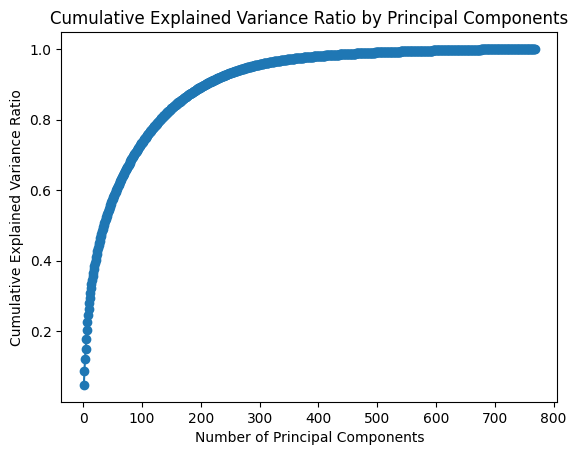

In [9]:
# Examine the cumulative variance explained by principal components
cumulative_variance_ratio = np.cumsum(pca_imdb.explained_variance_ratio_)
x_ticks = list(range(1,len(cumulative_variance_ratio)+1))
plt.plot(x_ticks, cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

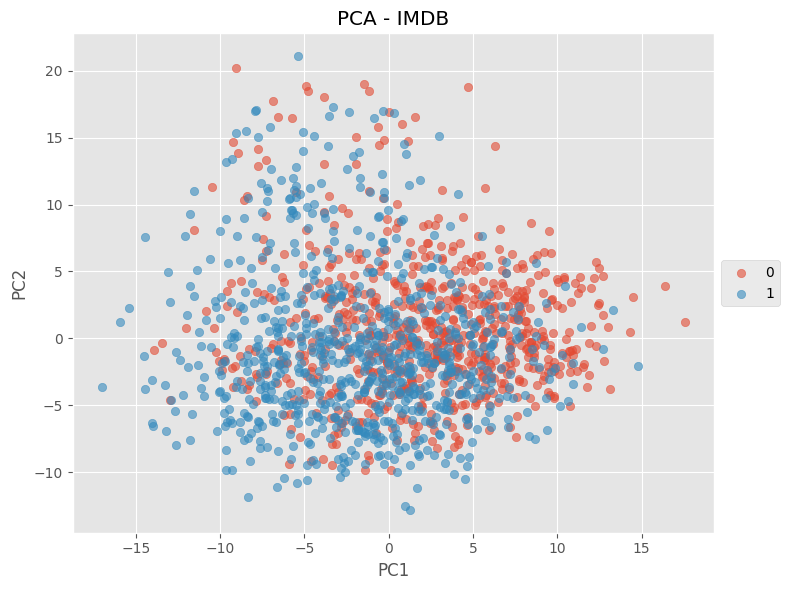

In [10]:
# Define label set and distinct colourmap
unique_labels = set(y_train)

plt.style.use('ggplot')

def plot_2d_comparison(x, y, n_data, unique_labels, x_label, y_label, title):
    plt.figure(figsize=(8,6))
    for i in unique_labels:
        plt.scatter(x[:n_data][y[:n_data] == i, 0], 
                    x[:n_data][y[:n_data] == i, 1], 
                    label=i, alpha=0.6)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualise the first two principal components
plot_2d_comparison(x_train_pca, y_train, 1500, unique_labels, 'PC1', 'PC2', 'PCA - IMDB')

In [11]:
for dim in [5, 10,  50, 100, 200]:
    model = LogisticRegression(random_state=42)
    model.fit(x_train_pca[:, :dim], y_train)

    pred = model.predict(x_test_pca[:, :dim])
    acc = accuracy_score(y_test, pred)
    print(f'Accuracy with {dim} dimensions: {acc}')

Accuracy with 5 dimensions: 0.7933
Accuracy with 10 dimensions: 0.8457
Accuracy with 50 dimensions: 0.882
Accuracy with 100 dimensions: 0.8886
Accuracy with 200 dimensions: 0.8932


### Isomap

c:\users\jzkho\appdata\local\programs\python\python38\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


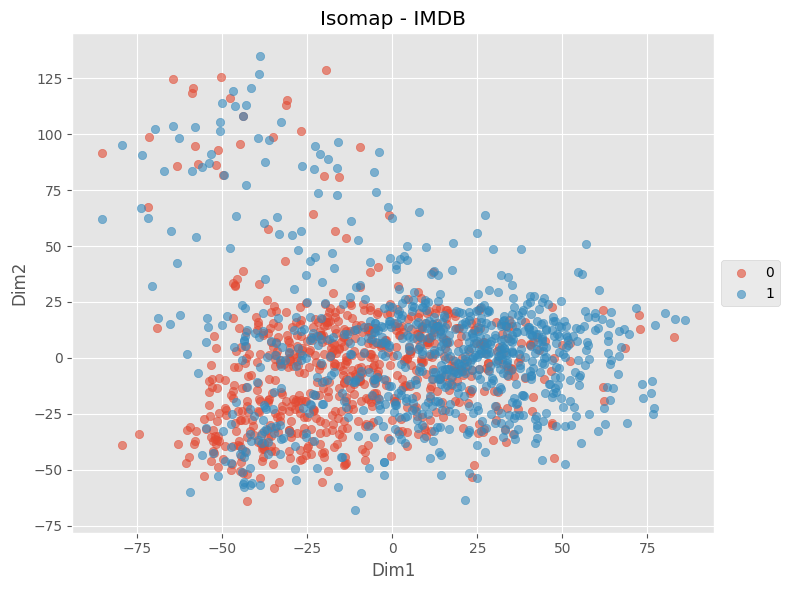

In [12]:
# Reduce the dimensionality of the dataset to two-dimensional using Isomap
isomap_imdb = Isomap(n_components=2, n_neighbors=5) 
# Fit the isomap algorithn using the first 30,000 data points to reduce compute time
x_train_isomap = isomap_imdb.fit_transform(x_train_scaled[:10000]) 

# Visualise the 2d representation of the dataset
plot_2d_comparison(x_train_isomap, y_train, 1500, unique_labels, 
               'Dim1', 'Dim2', 'Isomap - IMDB')

### Geodesic distance + MDS

In [18]:
# from numba import jit
# import gc
# import psutil
# import os
# import json

# # Function to get current memory usage
# def memory_usage_psutil():
#     process = psutil.Process(os.getpid())
#     mem = process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB
#     return mem

# # JIT-compiled function for constructing the graph
# @jit(nopython=True)
# def construct_graph(indices, distances, n_neighbors, n_samples):
#     graph = np.zeros((n_samples, n_samples))
#     for i in range(n_samples):
#         for j in range(1, n_neighbors):  # start from 1 to skip self-loop
#             graph[i, indices[i, j]] = distances[i, j]
#             graph[indices[i, j], i] = distances[i, j]
#     return graph

# # JIT-compiled function for constructing the expanded graph
# @jit(nopython=True)
# def construct_expanded_graph(indices, distances, neigh_graph, n_neighbors, n_train, n_samples):
#     n_total = n_train + n_samples
#     graph = np.zeros((n_total, n_total))
#     graph[:n_train, :n_train] = neigh_graph
#     for i in range(n_samples):
#         for j in range(1, n_neighbors):  # start from 1 to skip self-loop
#             graph[n_train+i, indices[i, j]] = distances[i, j]
#             graph[indices[i, j], n_train+i] = distances[i, j]
#     return graph

# def compute_geodesic_distances(data, n_neighbors=10, training=False, faiss_index=None, neigh_graph=None):
#     print(f"Memory usage at start: {memory_usage_psutil()} MB")

#     if training:
#         # Use FAISS to find approximate nearest neighbors
#         d = data.shape[1]
#         faiss_index = faiss.IndexFlatL2(d)
#         faiss_index.add(data)
#         distances, indices = faiss_index.search(data, n_neighbors)

#         # Construct sparse neighborhood graph
#         n_samples = data.shape[0]
#         print(f"Memory usage before constructing graph: {memory_usage_psutil()} MB")
#         graph = construct_graph(indices, distances, n_neighbors, n_samples)
#         print(f"Memory usage after constructing graph: {memory_usage_psutil()} MB")

#         # Compute geodesic distances using the shortest path algorithm
#         print(f"Memory usage before shortest path: {memory_usage_psutil()} MB")
#         geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
#         print(f"Memory usage after shortest path: {memory_usage_psutil()} MB")
#     else:
#         # Use trained FAISS index to find approximate nearest neighbors
#         n_train = faiss_index.ntotal
#         n_samples = data.shape[0]
#         print(f"Memory usage before searching: {memory_usage_psutil()} MB")
#         distances, indices = faiss_index.search(data, n_neighbors)

#         # Construct sparse neighborhood graph
#         print(f"Memory usage before constructing expanded graph: {memory_usage_psutil()} MB")
#         graph = construct_expanded_graph(indices, distances, neigh_graph, n_neighbors, n_train, n_samples)
#         print(f"Memory usage after constructing expanded graph: {memory_usage_psutil()} MB")

#         # Compute geodesic distances using the shortest path algorithm for all data
#         print(f"Memory usage before shortest path: {memory_usage_psutil()} MB")
#         geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
#         print(f"Memory usage after shortest path: {memory_usage_psutil()} MB")

#         # Extract the geodesic distances matrix for only new data
#         geodesic_distances = geodesic_distances[n_train:, n_train:]
    
#     # Explicitly call garbage collector
#     gc.collect()
#     print(f"Memory usage after garbage collection: {memory_usage_psutil()} MB")

#     return geodesic_distances, faiss_index, graph

# start_time = time.time()
# # Compute geodesic distances for mnist dataset (training)
# n_neighbors = 5
# geodesic_distances, faiss_index, neigh_graph = compute_geodesic_distances(X_train_vec, n_neighbors=n_neighbors, training=True)
# end_time = time.time()

# # Calculate the elapsed time
# elapsed_time = end_time - start_time

# print(f"Time taken to run the function: {elapsed_time} seconds")
# # 15000: 117s

# print(geodesic_distances.shape)
# print(faiss_index.ntotal)

In [ ]:
# # Apply MDS on the geodesic distances
# mds = MDS(n_components=2, dissimilarity='precomputed')
# X_mds = mds.fit_transform(geodesic_distances)

# # Visualise the 2d representation of the dataset
# plot_2d_mnist(X_mds, y_train, 1500, unique_labels, 
#               'Dim1', 'Dim2', 'Isomap - MNIST')

In [19]:
# # Save the numpy array to a CSV file
# np.savetxt("geo_dist_imdb.csv", geodesic_distances, delimiter=",", fmt="%d")

In [9]:
# # Load data from CSV file
# geodesic_distances = np.loadtxt("geo_dist_imdb.csv", delimiter=",", dtype=np.float32)

# # Verify the loaded data
# print("Loaded data shape:", geodesic_distances.shape)

Loaded data shape: (60000, 60000)


### t-SNE

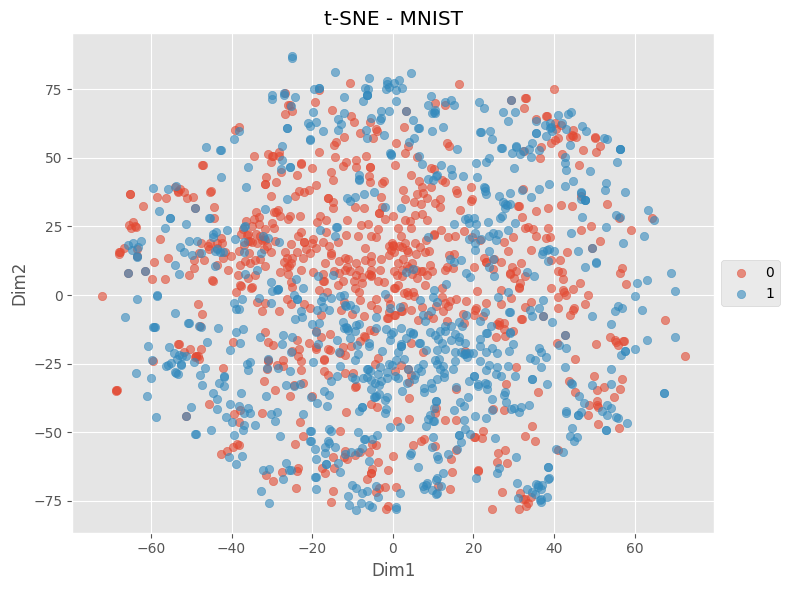

In [13]:
# Reduce the dimensionality of the dataset to two-dimensional using t-SNE
tsne_imdb = TSNE(n_components=2) 
x_train_tsne = tsne_imdb.fit_transform(x_train_scaled[:10000])

# Visualise the 2d representation of the dataset
plot_2d_comparison(x_train_tsne, y_train, 1500, unique_labels,
               'Dim1', 'Dim2', 't-SNE - MNIST')

### Autoencoder

In [125]:
# Set seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Set the dimensions for input and lower embeddings
input_dim = 768
encoded_dim = 50

def get_encoder(input_dim, encoded_dim, dataset, seed=5):
    """
    Define the encoder part of an autoencoder.
    
    Parameters:
    input_dim (int): Dimension of the input data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: Encoder model.
    """
    inputs = Input(shape=(input_dim,))
    x = Dense(1500, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(inputs)
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Dropout(0.5)(x)
    x = Dense(500, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Dropout(0.5)(x)
    encoded = Dense(encoded_dim, kernel_initializer=GlorotUniform(seed=seed))(x)
    encoder = Model(inputs, encoded, name=f'{dataset}_encoder')
    return encoder

def get_decoder(input_dim, encoded_dim, dataset, seed=5):
    """
    Define the decoder part of an autoencoder.
    
    Parameters:
    input_dim (int): Dimension of the output data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: Decoder model.
    """
    encoded_inputs = Input(shape=(encoded_dim,))
    x = Dense(500, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(encoded_inputs)
    x = Dropout(0.5)(x)
    x = Dense(1000, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Dropout(0.5)(x)
    x = Dense(1500, activation='relu', kernel_initializer=GlorotUniform(seed=seed))(x)
    x = Dropout(0.5)(x)
    decoded = Dense(input_dim, kernel_initializer=GlorotUniform(seed=seed))(x)
    decoder = Model(encoded_inputs, decoded, name=f'{dataset}_decoder')
    return decoder
    
def get_autoencoder(input_dim, encoded_dim, dataset, seed=5):
    """
    Construct the complete autoencoder by combining encoder and decoder.
    
    Parameters:
    input_dim (int): Dimension of the input data.
    encoded_dim (int): Dimension of the encoded representation.
    dataset (str): Name of the dataset.
    seed (int): Random seed for weight initialization.
    
    Returns:
    Model: Autoencoder model.
    """
    encoder = get_encoder(input_dim, encoded_dim, dataset, seed=seed)
    decoder = get_decoder(input_dim, encoded_dim, dataset, seed=seed)
    inputs = Input(shape=(input_dim,))
    encoded = encoder(inputs)
    decoded = decoder(encoded)
    autoencoder = Model(inputs=inputs, outputs=decoded, name=f'{dataset}_autoencoder')
    return autoencoder

imdb_autoencoder = get_autoencoder(input_dim, encoded_dim, 'imdb', seed=seed)
imdb_encoder = imdb_autoencoder.get_layer('imdb_encoder')
imdb_autoencoder.summary()

Model: "imdb_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 768)]             0         
                                                                 
 imdb_encoder (Functional)   (None, 50)                3180050   
                                                                 
 imdb_decoder (Functional)   (None, 768)               3180768   
                                                                 
Total params: 6,360,818
Trainable params: 6,360,818
Non-trainable params: 0
_________________________________________________________________


In [126]:
gc.collect()

31605

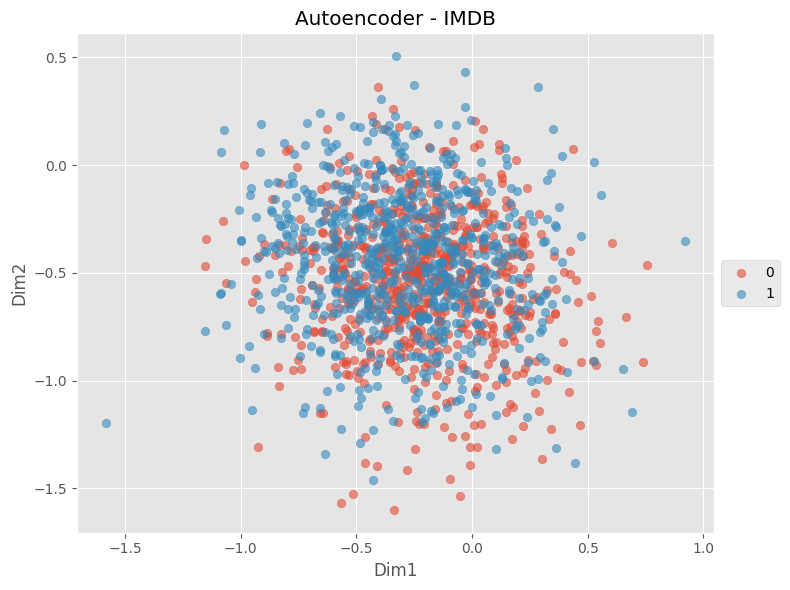

In [127]:
untrained_encodings = imdb_encoder(x_train_scaled).numpy()

plot_2d_comparison(untrained_encodings, y_train, 1500, unique_labels, 
               'Dim1', 'Dim2', 'Autoencoder - IMDB')

In [128]:
gc.collect()

3810

Final Training Loss: 0.6420, Final Validation Loss: 0.5551


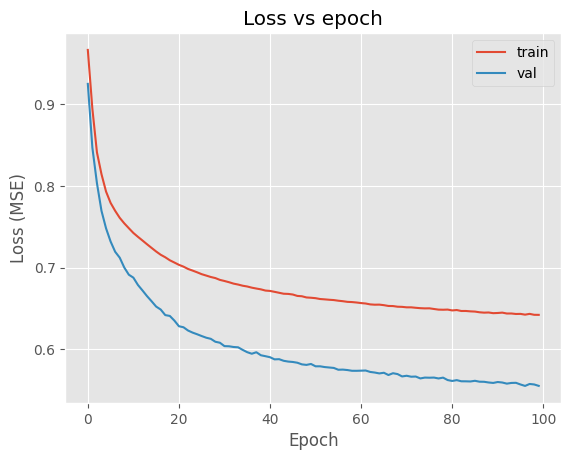

In [129]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


# Train the autoencoder over 100 epochs
imdb_autoencoder.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')
history_imdb = imdb_autoencoder.fit(x_train_scaled, x_train_scaled, epochs=100, batch_size=32, 
                                    validation_data=(x_test_scaled, x_test_scaled), callbacks=[early_stopping], verbose=0)

# Print final training and validation loss (MSE)
final_train_loss = history_imdb.history['loss'][-1]
final_val_loss = history_imdb.history['val_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}, Final Validation Loss: {final_val_loss:.4f}")

# Examine the training and validation loss (MSE) over epochs
plt.plot(history_imdb.history['loss'], label='train')
plt.plot(history_imdb.history['val_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Loss vs epoch")
plt.legend()

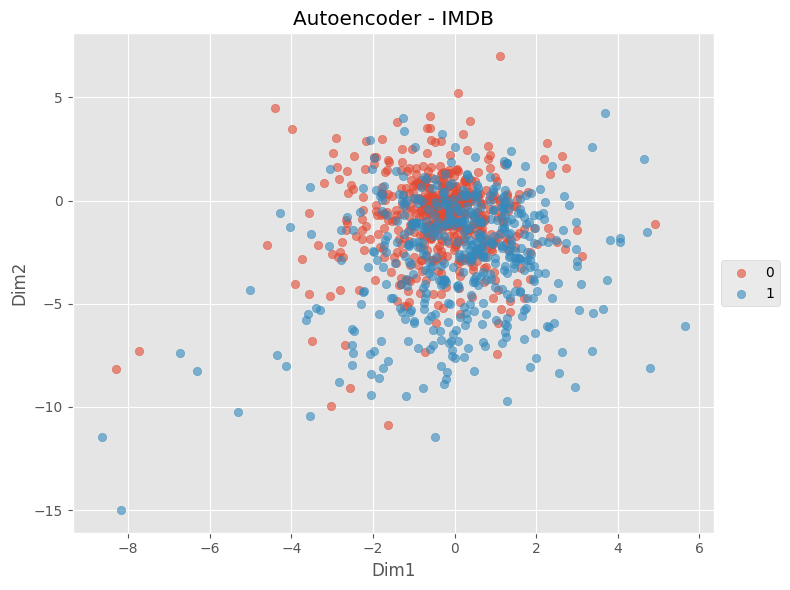

In [131]:
# Compute the encodings after training
trained_encodings_imdb = imdb_encoder(x_test_scaled).numpy()

# Visualise the trained latent encodings
plot_2d_comparison(trained_encodings_imdb, y_test, 1000, unique_labels, 
               'Dim1', 'Dim2', 'Autoencoder - IMDB')

In [132]:
# Generate encodings for train data
trained_imdb_encodings = imdb_encoder(x_train_scaled).numpy()

# Train logistic classifier using standard autoencoder's embeddings
model = LogisticRegression(random_state=seed, max_iter=1000)
model.fit(trained_imdb_encodings, y_train)

# Generate encodings for test data
predicted_imdb_encodings = imdb_encoder(x_test_scaled).numpy()

# Validate classification accuracy on test data
pred = model.predict(predicted_imdb_encodings)
acc = accuracy_score(y_test, pred)
print(acc)

0.7263


In [145]:
dims = [5, 10, 50, 100, 200]
accs = []

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Directory to save the models and results
save_dir = 'imdb'
os.makedirs(save_dir, exist_ok=True)

for d in dims:
    # Set seed for reproducibility
    seed = 42
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Build and train the autoencoder for the IMDB dataset
    imdb_autoencoder = get_autoencoder(input_dim=x_train_scaled.shape[1], encoded_dim=d, dataset='imdb', seed=seed)
    imdb_encoder = imdb_autoencoder.get_layer('imdb_encoder')
    imdb_autoencoder.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')
    
    # Train the model
    start_time = time.time()
    history_imdb = imdb_autoencoder.fit(x_train_scaled, x_train_scaled, epochs=100, batch_size=32, 
                                        validation_data=(x_test_scaled, x_test_scaled), callbacks=[early_stopping], verbose=0)
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time
    print(f'Time taken to train the model with {d} dimensions: {training_time} seconds')

    # Save the model
    model_path = os.path.join(save_dir, f'autoencoder_{d}d.keras')
    imdb_autoencoder.save(model_path)
    print(f'Model with {d} dimensions saved at: {model_path}')

    # Save the training history
    history_path = os.path.join(save_dir, f'autoencoder_{d}d_history.json')
    with open(history_path, 'w') as f:
        json.dump(history_imdb.history, f)
    print(f'History for {d} dimensions saved at: {history_path}')

    # Generate encodings for train data
    trained_imdb_encodings = imdb_encoder(x_train_scaled).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_imdb_encodings, y_train)

    # Generate encodings for test data
    predicted_imdb_encodings = imdb_encoder(x_test_scaled).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_imdb_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')

    # Save model parameters and results
    results = {
        'embedding_dim': d,
        'accuracy': acc,
        'training_time': training_time,
        'model_path': model_path,
        'history_path': history_path
    }
    results_path = os.path.join(save_dir, f'autoencoder_{d}d_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f)
    print(f'Results for {d} dimensions saved at: {results_path}')

    del history_imdb
    del imdb_autoencoder
    del imdb_encoder
    del trained_imdb_encodings
    del predicted_imdb_encodings
    del model
    del results

    gc.collect()

### GCAE

In [48]:
class GCAETrainer(Model):
    """
    A trainer class for a GCAE that handles model training and evaluation.
    """
    def __init__(self, dataset, input_dim=3, embedding_dim=2, n_neighbors=10, alpha=10, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.dataset = dataset
        self.n_neighbors = n_neighbors
        self.gcae = get_autoencoder(self.input_dim, self.embedding_dim, self.dataset)
        self.encoder = self.gcae.get_layer(f'{self.dataset}_encoder')
        self.alpha = alpha

        # FAISS index and training data
        self.faiss_index = None
        self.neigh_graph = None
        self.train_geo_dist = None
        self.train_geo_dist_max = None
        self.test_geo_dist = None
        
        # Define the loss metrics to track and log
        self.total_loss_metric = Mean(name='total_loss')
        self.reconstruction_loss_metric = Mean(name='reconstruction_loss')
        self.geodesic_loss_metric = Mean(name='geodesic_loss')

    @property
    def metrics(self):
        """
        Returns a list of metrics used in training and evaluation.
        """
        return [self.total_loss_metric, self.reconstruction_loss_metric, self.geodesic_loss_metric]

    @staticmethod
    @jit(nopython=True)
    def construct_graph(indices, distances, n_neighbors, n_samples):
        graph = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(1, n_neighbors):  # start from 1 to skip self-loop
                graph[i, indices[i, j]] = np.sqrt(distances[i, j])
                graph[indices[i, j], i] = np.sqrt(distances[i, j])
        return graph

    @staticmethod
    @jit(nopython=True)
    def construct_expanded_graph(indices, distances, neigh_graph, n_neighbors, n_train, n_samples):
        n_total = n_train + n_samples
        graph = np.zeros((n_total, n_total))
        graph[:n_train, :n_train] = neigh_graph
        for i in range(n_samples):
            for j in range(1, n_neighbors):  # start from 1 to skip self-loop
                graph[n_train+i, indices[i, j]] = np.sqrt(distances[i, j])
                graph[indices[i, j], n_train+i] = np.sqrt(distances[i, j])
        return graph

    def compute_geodesic_distances(self, data, training=False):
    
        if training:
            # Use FAISS to find approximate nearest neighbors
            d = data.shape[1]
            faiss_index = faiss.IndexFlatL2(d)
            faiss_index.add(data)
            distances, indices = faiss_index.search(data, self.n_neighbors)
            self.faiss_index = faiss_index
    
            # Construct sparse neighborhood graph
            n_samples = data.shape[0]
            print(f"Memory usage before constructing graph: {memory_usage_psutil()} MB")
            graph = self.construct_graph(indices, distances, self.n_neighbors, n_samples)
            self.neigh_graph = graph
            print(f"Memory usage after constructing graph: {memory_usage_psutil()} MB")
    
            # Compute geodesic distances using the shortest path algorithm
            print(f"Memory usage before shortest path: {memory_usage_psutil()} MB")
            geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
            print(f"Memory usage after shortest path: {memory_usage_psutil()} MB")
            geodesic_distances = np.float32(geodesic_distances)
            self.train_geo_dist = geodesic_distances
            self.train_geo_dist_max = np.max(geodesic_distances)

        else:
            # Use trained FAISS index to find approximate nearest neighbors
            n_train = self.faiss_index.ntotal
            n_samples = data.shape[0]
            print(f"Memory usage before searching: {memory_usage_psutil()} MB")
            distances, indices = self.faiss_index.search(data, self.n_neighbors)
    
            # Construct sparse neighborhood graph
            print(f"Memory usage before constructing expanded graph: {memory_usage_psutil()} MB")
            graph = self.construct_expanded_graph(indices, distances, self.neigh_graph, self.n_neighbors, n_train, n_samples)
            print(f"Memory usage after constructing expanded graph: {memory_usage_psutil()} MB")
    
            # Compute geodesic distances using the shortest path algorithm for all data
            print(f"Memory usage before shortest path: {memory_usage_psutil()} MB")
            geodesic_distances = shortest_path(csgraph=graph, method='D', directed=False)
            print(f"Memory usage after shortest path: {memory_usage_psutil()} MB")
    
            # Extract the geodesic distances matrix for only new data
            geodesic_distances = geodesic_distances[n_train:, n_train:]
            geodesic_distances = np.float32(geodesic_distances)
            self.test_geo_dist = geodesic_distances
        
        gc.collect()
        
        return geodesic_distances
    
    def compute_geodesic_loss(self, z, geodesic_distances, batch_indices):
        """
        Computes geodesic distance loss.
        """
        # Calculate the pairwise Euclidean distances in the latent space
        z_distances = tf.norm(z[:, tf.newaxis] - z, axis=2)
        # Calculate the geodesic distance loss
        geodesic_distances_batch = tf.gather(tf.gather(geodesic_distances, batch_indices, axis=0), batch_indices, axis=1)
        distance_loss = tf.reduce_mean((z_distances - geodesic_distances_batch) ** 2) / self.train_geo_dist_max
        return distance_loss
        
    def _get_losses(self, x, batch_indices, training=False):
        """
        Computes model losses from inputs.
        """
        reconstructions = self.gcae(x, training=training)
        latent = self.encoder(x)
        # Compute the reconstruction loss
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions) ** 2)
        )
        # Compute the geodesic loss
        if training:
            geodesic_loss = self.compute_geodesic_loss(z=latent, geodesic_distances=self.train_geo_dist, 
                                                       batch_indices=batch_indices)
        else:    
            geodesic_loss = self.compute_geodesic_loss(z=latent, geodesic_distances=self.test_geo_dist, 
                                                       batch_indices=batch_indices)
        # Cmpute the total loss
        total_loss = reconstruction_loss + self.alpha * geodesic_loss
        return total_loss, reconstruction_loss, geodesic_loss

    def train_step(self, data):
        """
        Performs one training step using a single batch of data.
        """
        x, batch_indices = data
        with tf.GradientTape() as tape:
            total_loss, reconstruction_loss, geodesic_loss = self._get_losses(x, batch_indices, training=True)
        grads = tape.gradient(total_loss, self.gcae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.gcae.trainable_variables))

        # Update loss metrics
        self.total_loss_metric.update_state(total_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.geodesic_loss_metric.update_state(geodesic_loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        Evaluates the model using a single batch of data.
        """
        x, batch_indices = data
        total_loss, reconstruction_loss, geodesic_loss = self._get_losses(x, batch_indices, training=False)

        # Update loss metrics
        self.total_loss_metric.update_state(total_loss)
        self.reconstruction_loss_metric.update_state(reconstruction_loss)
        self.geodesic_loss_metric.update_state(geodesic_loss)
        return {m.name: m.result() for m in self.metrics}

# Define the gcae trainer
gcae_trainer = GCAETrainer(input_dim=x_train_scaled.shape[1], embedding_dim=encoded_dim, n_neighbors=10, alpha=0.01, dataset='imdb')

# Ensure eager execution
tf.config.run_functions_eagerly(True)

# # Generate Geodesic distance matrix for train and validation data
# train_start_time = time.time()
# train_geo_dist = gcae_trainer.compute_geodesic_distances(x_train_scaled, training=True)
# train_end_time = time.time()
# print(f"Time taken to compute geodesic distances for train data: {train_end_time - train_start_time} seconds") # 938.2635560035706 seconds

# # Save the numpy array to a CSV file
# np.savetxt("imdb_train_geo_dist.csv", gcae_trainer.train_geo_dist, delimiter=",", fmt="%d")

# val_start_time = time.time()
# val_geo_dist = gcae_trainer.compute_geodesic_distances(x_test_scaled, training=False)
# val_end_time = time.time()
# print(f"Time taken to compute geodesic distances for val data: {val_end_time - val_start_time} seconds") # 1577.2979669570923 seconds

# # Save the numpy array to a CSV file
# np.savetxt("imdb_test_geo_dist.csv", gcae_trainer.test_geo_dist, delimiter=",", fmt="%d")

In [49]:
# Load data from CSV file
train_geo_dist = np.loadtxt("imdb_train_geo_dist.csv", delimiter=",", dtype=np.float32)
val_geo_dist = np.loadtxt("imdb_test_geo_dist.csv", delimiter=",", dtype=np.float32)

# Verify the loaded data
print("Loaded IMDB train geo dist shape:", train_geo_dist.shape)
print("Loaded IMDB test geo dist shape:", val_geo_dist.shape)

In [50]:
gcae_trainer.train_geo_dist = train_geo_dist
gcae_trainer.train_geo_dist_max = np.max(train_geo_dist)
gcae_trainer.test_geo_dist = val_geo_dist

In [51]:
# Convert data to TensorFlow Dataset
batch_size = 32
train_data = tf.data.Dataset.from_tensor_slices((x_train_scaled.astype(np.float32), np.arange(len(x_train_scaled))))
train_data = train_data.batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices((x_test_scaled.astype(np.float32), np.arange(len(x_test_scaled))))
val_data = val_data.batch(batch_size)

# Create an EarlyStopping callback to terminate training if the validation total loss doesn't immprove after 10 epochs
early_stopping = EarlyStopping(monitor='val_total_loss', patience=10, mode='min', restore_best_weights=True)

# Train the autoencoder over 100 epochs
gcae_trainer.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0002))
history_gc_imdb = gcae_trainer.fit(train_data, validation_data=val_data, epochs=100, callbacks=[early_stopping], verbose=1)

# Print final training and validation loss (MSE)
final_train_loss = history_gc_imdb.history['total_loss'][-1]
final_val_loss = history_gc_imdb.history['val_total_loss'][-1]
print(f"Final Training Loss: {final_train_loss:.4f}, Final Validation Loss: {final_val_loss:.4f}")

# Examine the training and validation loss (MSE) over epochs
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.plot(history_gc_imdb.history['total_loss'], label='train')
plt.plot(history_gc_imdb.history['val_total_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Total Loss (MSE + Geodesic Loss)")
plt.title("Total Loss vs epoch")
plt.legend()

plt.subplot(1,3,2)
plt.plot(history_gc_imdb.history['reconstruction_loss'], label='train')
plt.plot(history_gc_imdb.history['val_reconstruction_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Reconstruction Loss vs epoch")
plt.legend()

plt.subplot(1,3,3)
plt.plot(history_gc_imdb.history['geodesic_loss'], label='train')
plt.plot(history_gc_imdb.history['val_geodesic_loss'], label='val')
plt.xlabel("Epoch")
plt.ylabel("Geodesic Loss")
plt.title("Geodesic Loss vs epoch")
plt.legend()
plt.show()

In [ ]:
imdb_gc_encoder = gcae_trainer.gcae.get_layer('imdb_encoder')

# Compute the encodings after training
trained_encodings_gc_imdb = imdb_gc_encoder(x_test_scaled).numpy()

# Visualise the trained latent encodings
plot_2d_mnist(trained_encodings_gc_imdb, y_test, 1000, unique_labels, 
               'Dim1', 'Dim2', 'GCAE - MNIST')

In [ ]:
mnist_gc_autoencoder = gcae_trainer.gcae

np.random.seed(5)
inx = np.random.choice(x_test.shape[0], 10, replace=False)
reconstructed_mnist_images_gc = mnist_gc_autoencoder(x_test[inx])

f, axs = plt.subplots(2, 10, figsize=(15, 4))
for j in range(10):
    axs[0, j].imshow(x_test[inx][j], cmap='binary')
    axs[1, j].imshow(reconstructed_mnist_images_gc[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.show()

### Logistic Regression

In [ ]:
# Train logistic classifier using original data
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Validate accuracy using test data
pred = model.predict(X_test)
acc = accuracy_score(y_test, pred)
print(acc)

In [ ]:
seed = 42
input_shape = (28, 28, 1)
dims = [2, 10, 20, 50, 100]
accs = []

for d in dims:
    # Build and train the CNN autoencoder for the MNIST dataset
    mnist_autoencoder = get_cnn_autoencoder(input_shape, d, 'mnist')
    mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')
    mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
    history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

    # Generate encodings for train data
    trained_mnist_encodings = mnist_encoder(x_train).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_mnist_encodings, y_train)

    # Generate encodings for test data
    predicted_mnist_encodings = mnist_encoder(x_test).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_mnist_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')

In [ ]:
seed = 42
input_shape = (28, 28, 1)
dims = [2, 10, 20, 50, 100]
accs = []

for d in dims:
    # Build and train the CNN autoencoder for the MNIST dataset
    mnist_autoencoder = get_cnn_autoencoder(input_shape, d, 'mnist')
    mnist_encoder = mnist_autoencoder.get_layer('mnist_cnn_encoder')
    mnist_autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
    history_mnist = mnist_autoencoder.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=early_stopping, verbose=0)

    # Generate encodings for train data
    trained_mnist_encodings = mnist_encoder(x_train).numpy()

    # Train logistic classifier using standard autoencoder's embeddings
    model = LogisticRegression(random_state=seed, max_iter=1000)
    model.fit(trained_mnist_encodings, y_train)

    # Generate encodings for test data
    predicted_mnist_encodings = mnist_encoder(x_test).numpy()
    
    # Validate classification accuracy on test data
    pred = model.predict(predicted_mnist_encodings)
    acc = accuracy_score(y_test, pred)
    accs.append(acc)
    print(f'Accuracy with {d} dimensions: {acc}')